In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [2]:
root = '/content/drive/MyDrive/hack/datasets/'

In [3]:
x_train = np.load(root+'x_train.npy')
y_train = np.load(root+'y_train.npy')
x_test = np.load(root+'x_test.npy')
y_test = np.load(root+'y_test.npy')

In [4]:
mSpec_input=keras.layers.Input(shape=(128,219,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

skip_x = x
skip_x = keras.layers.Conv2D(96,3,strides=(2,4),padding='same')(skip_x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x = keras.layers.Add()([x,skip_x])
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(4,activation='softmax')(x)


mSpec_model=keras.Model(mSpec_input, output, name="mSpecModel")

In [6]:
mSpec_model.summary()

Model: "mSpecModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mSpecInput (InputLayer)        [(None, 128, 219, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 73, 32)   832         ['mSpecInput[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 73, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                         

In [7]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [8]:
file_name = root + 'model/mSpec_model-001.h5'
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [9]:
history = mSpec_model.fit(
    x_train,
    y_train,
    batch_size = 16,
    validation_data=(x_test, y_test),
    epochs=200,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/200
1284/1284 [==============================] - 26s 10ms/step - loss: 1.3792 - sparse_categorical_accuracy: 0.2975 - val_loss: 1.1565 - val_sparse_categorical_accuracy: 0.5279 - lr: 0.0010
Epoch 2/200
1284/1284 [==============================] - 10s 8ms/step - loss: 1.2956 - sparse_categorical_accuracy: 0.3536 - val_loss: 1.1928 - val_sparse_categorical_accuracy: 0.5101 - lr: 0.0010
Epoch 3/200
1284/1284 [==============================] - 10s 8ms/step - loss: 1.2691 - sparse_categorical_accuracy: 0.3723 - val_loss: 1.1950 - val_sparse_categorical_accuracy: 0.4993 - lr: 0.0010
Epoch 4/200
1284/1284 [==============================] - 10s 8ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.1676 - val_sparse_categorical_accuracy: 0.5127 - lr: 0.0010
Epoch 5/200
1284/1284 [==============================] - 10s 8ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.3892 - val_loss: 1.1239 - val_sparse_categorical_accuracy: 0.5199 - lr: 0.0010
Epoch 6/200
12

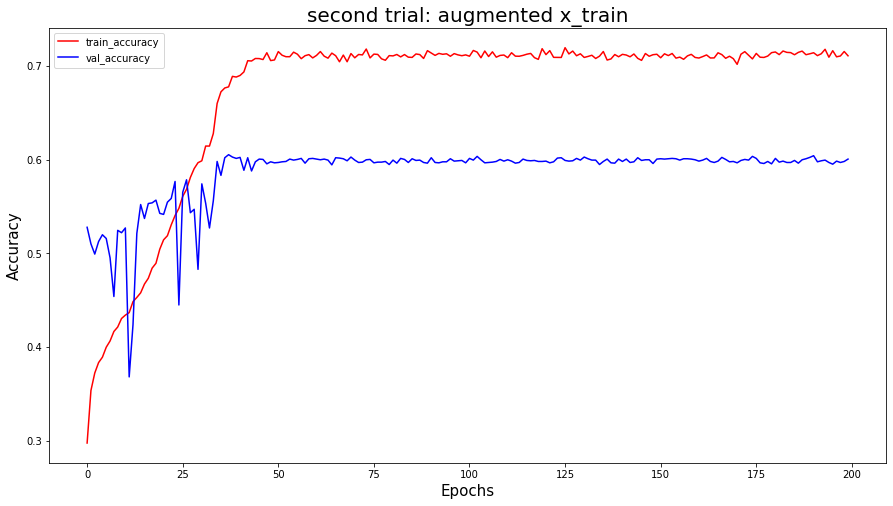

In [10]:
plt.figure(figsize=(15,8))

plt.plot(history.history['sparse_categorical_accuracy'], label = 'train_accuracy', linestyle='solid', color='r')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy', linestyle='solid', color='b')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.title('second trial: augmented x_train', fontsize = 20)
plt.show()

In [11]:
y_pred = mSpec_model.predict(x_test)

In [12]:
confusion_matrix(np.argmax(y_pred, axis = 1), y_test)

array([[1039,  207,   79,   19],
       [ 300,  397,  135,   36],
       [ 112,  116,  118,   43],
       [   6,   26,   23,  104]])

In [13]:
target_names=['Normal', 'Crackle', 'Wheeze', 'Both']

clf_report = classification_report(y_test, np.argmax(y_pred, axis = 1), target_names=target_names, output_dict=True)
print(classification_report(y_test, np.argmax(y_pred, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.77      0.71      0.74      1457
     Crackle       0.46      0.53      0.49       746
      Wheeze       0.30      0.33      0.32       355
        Both       0.65      0.51      0.58       202

    accuracy                           0.60      2760
   macro avg       0.55      0.52      0.53      2760
weighted avg       0.62      0.60      0.61      2760



trial 1 의 classification report

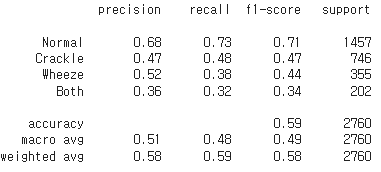

- accuracy 1% 증가<br/>
- Both class 전체적으로 증가 <br/>
- 하지만 Wheeze class 는 감소

In [14]:
with open( root+ "clf_report_customized_resnet.txt", "w") as text_file:
    print(classification_report(y_test, np.argmax(y_pred, axis = 1), target_names=target_names), file=text_file)